<a href="https://colab.research.google.com/github/C3Suryansu/Odia-writing-recognition-Webapp/blob/main/Odia_numerical_classification_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive 
drive.mount('drive/', force_remount = True)

Mounted at drive/


In [ ]:
# !pip install wandb -qqq
# import wandb
# from wandb.keras import WandbCallback
# wandb.login()

# run = wandb.init(project='onr')
# config = wandb.config
# config.learning_rate = 0.001
# config.batch_size = 64
# config.validation_split = 0.2
# config.target_size = (32, 32)
# config.random_state = 42

In [ ]:
path = '/content/drive/MyDrive/ONR Results/Consistent Results/'

In [ ]:
!mkdir data
!unrar x "/content/drive/MyDrive/Odia Numericals/IITBBS Odia Numeral DATABASE.rar" -d data

Streaming output truncated to the last 5000 lines.
Extracting  data/9/428.jpg                                                 3%  OK 
Extracting  data/9/429.jpg                                                 3%  OK 
Extracting  data/9/43.jpg                                                  3%  OK 
Extracting  data/9/430.jpg                                                 3%  OK 
Extracting  data/9/432.jpg                                                 3%  OK 
Extracting  data/9/433.jpg                                                 3%  OK 
Extracting  data/9/434.jpg                                                 3%  OK 
Extracting  data/9/435.jpg                                                 3%  OK 
Extracting  data/9/436.jpg                                                 3%  OK 
Extracting  data/9/437.jpg                                                 3%  OK 
Extracting  data/9/438.jpg   

In [ ]:
!nvidia-smi

Sun Sep 19 05:18:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab.patches import cv2_imshow
import cv2

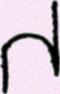

(94, 60, 3)

In [ ]:
img = cv2.imread('/content/data/9/219.jpg')
cv2_imshow(img)
img.shape

# Converting into dataframe

In [ ]:
import sys
import os 
import pandas as pd
data_dir = "data/"
num_of_classes = len(os.listdir(data_dir))
print("Classes:",num_of_classes)


# For undersampling data
images = []
labels = []
min_files = sys.maxsize
for label in os.listdir(data_dir):
    files = os.listdir(os.path.join(data_dir, label))
    min_files = min(len(files), min_files)
    for file in files:
        images.append(os.path.join(data_dir,label,file))
        labels.append(label)
    
print(min_files)

df = pd.DataFrame({"images": images, "labels":labels})
df = df.groupby('labels').head(min_files).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

Classes: 10
500


In [ ]:
import cv2
err_ind = []
for i in range(5000):
  try:
    img = cv2.imread(df.iloc[i]['images'])
    sh = img.shape
  except:
    err_ind.append(i)
df = df.drop(labels = err_ind, axis = 0)
df.head()

,images,labels
0,data/0/157.jpg,0
1,data/0/15.jpg,0
2,data/5/901 (87).tif,5
3,data/7/77 (58).tif,7
4,data/0/001_447 (220).tif,0


In [ ]:
df = df.sample(frac=1).reset_index(drop=True)
n = df.shape[0]
!mkdir newData
new_img_names = []
for i in range(n):
  img = cv2.imread(df.iloc[i]['images'])
  cv2.imwrite('newData/' + str(i) + '.jpg', img)
  new_img_names.append(str(i) + '.jpg')
df['images'] = new_img_names
df.head()

,images,labels
0,0.jpg,2
1,1.jpg,0
2,2.jpg,5
3,3.jpg,4
4,4.jpg,4


In [ ]:
df.to_csv('/content/data.csv', index = None)
newdf = pd.read_csv('/content/data.csv')
newdf.head()

,images,labels
0,0.jpg,2
1,1.jpg,0
2,2.jpg,5
3,3.jpg,4
4,4.jpg,4


# Training Model on the dataframe

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import activations
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

def create_model(optimizer):
  vggmodel = VGG16(weights='imagenet', include_top = False, input_shape = (32, 32, 3),pooling='max')
  for layer in vggmodel.layers[0:15]:
    layer.trainable = False
  x = vggmodel.output
  x = Dense(64, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = Dense(10, activation='softmax')(x)

  model = models.Model(inputs = vggmodel.input, outputs = x)
  # optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001)
  
  model.compile(loss='categorical_crossentropy',
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=1e-7, verbose=1)
import numpy as np


In [ ]:
# new_labels = [str(i) for i in df['labels']]
# df['labels'] = new_labels

In [ ]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

In [ ]:
train_data_gen = ImageDataGenerator(rescale = 1./255,
                                          shear_range = 0.1,
                                          zoom_range = 0.2)
val_data_gen = ImageDataGenerator(rescale = 1./255)

train_generator = train_data_gen.flow_from_dataframe(dataframe = train_df,
                                                          directory = 'newData',
                                                          x_col = 'images',
                                                          y_col = 'labels',
                                                          batch_size = 32,
                                                          class_mode = 'categorical',
                                                          target_size = (32, 32))
test_generator = val_data_gen.flow_from_dataframe(dataframe = test_df,
                                                        directory = 'newData',
                                                        x_col = 'images',
                                                        y_col = 'labels',
                                                        batch_size = 32,
                                                        class_mode = 'categorical',
                                                        target_size = (32, 32))
model = create_model(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
history = model.fit(train_generator,
              validation_data = test_generator,
              verbose = 1,
              epochs = 50, 
              callbacks = [reduce_lr])  

Found 3997 validated image filenames belonging to 10 classes.
Found 1000 validated image filenames belonging to 10 classes.


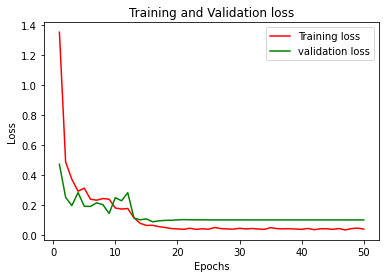

In [ ]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_graph', dpi = 500)
plt.show()
plt.close()

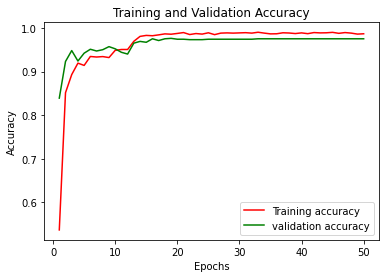

In [ ]:
import matplotlib.pyplot as plt
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'r', label='Training accuracy')
plt.plot(epochs, acc_val, 'g', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('accuracy_graph', dpi = 500)
plt.show()
plt.close()

In [ ]:
import keras
saved_model = tf.keras.models.load_model('/content/drive/MyDrive/onr_weights.h5')
saved_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [ ]:
from tensorflow.keras.models import Model
fe_model = Model(inputs = saved_model.input, outputs = saved_model.layers[-2].output)
fe_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0  

In [ ]:
# model.save('/content/drive/MyDrive/Weights/onr_weights_cpu.h5')

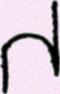

(94, 60, 3)

In [ ]:
img = cv2.imread('/content/data/9/219.jpg')
cv2_imshow(img)
img.shape

In [ ]:
img = cv2.resize(img, (32, 32))

In [ ]:
img = np.expand_dims(img, axis = 0)
img.shape

(1, 32, 32, 3)

In [ ]:
model.predict(img)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [ ]:
train_generator.shuffle = False
train_generator.reset()

test_generator.shuffle = False
test_generator.reset()

x_train = fe_model.predict(train_generator)
y_train = train_generator.labels

x_test = fe_model.predict(test_generator)
y_test = test_generator.labels

In [ ]:
res = saved_model.predict(test_generator)
predicted = []
for i in res:
  predicted.append(np.argmax(i))
import sklearn
dnn_acc = sklearn.metrics.accuracy_score(predicted, y_test)

In [ ]:
print(np.array(predicted).shape)
print(np.array(y_test).shape)

(1000,)
(1000,)


In [ ]:
np.argmax(res[0])

2

In [ ]:
x_train.shape

(3997, 64)

In [ ]:
len(x_train)

3997

In [ ]:
len(y_train)

3997

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
from sklearn.metrics import accuracy_score
lr_acc = accuracy_score(y_pred, y_test)
lr_acc

0.997

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state = 42)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
rfc_acc = accuracy_score(y_pred, y_test)
rfc_acc

0.996

In [ ]:
from sklearn.svm import SVC
svc = SVC(random_state = 42)
svc.fit(x_train, y_train)
y_pred = svc.predict(x_test)
svc_acc = accuracy_score(y_pred, y_test)
svc_acc

0.991

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc =  DecisionTreeClassifier(random_state = 42)
dtc.fit(x_train, y_train)
y_pred = dtc.predict(x_test)
dt_acc = accuracy_score(y_pred, y_test)
dt_acc

0.989

In [ ]:
from sklearn.naive_bayes import GaussianNB
nbc = GaussianNB()
nbc.fit(x_train, y_train)
y_pred = nbc.predict(x_test)
nb_acc = accuracy_score(y_pred, y_test)
nb_acc

0.995

In [ ]:
from xgboost import XGBClassifier
from matplotlib import pyplot
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
xgb_acc = accuracy_score(y_pred, y_test)
xgb_acc

0.995

In [ ]:
best_model = pd.DataFrame({"Model":["VGG16 + DNN","VGG16 + Logistic Regression","VGG16 + Decision Tree Classifier","VGG16 + Random Forest Classifier","VGG16 + SVM Classifier","VGG16 + Naive Bayes"],"Accuracy(%)":[dnn_acc*100,lr_acc*100,dt_acc*100,rfc_acc*100,svc_acc*100,nb_acc*100]})
best_model = best_model.sort_values(by="Accuracy(%)",ascending=False)
best_model.reset_index()
best_model = best_model.round(2)
best_model

,Model,Accuracy(%)
0,VGG16 + DNN,99.8
1,VGG16 + Logistic Regression,99.7
3,VGG16 + Random Forest Classifier,99.6
5,VGG16 + Naive Bayes,99.5
4,VGG16 + SVM Classifier,99.1
2,VGG16 + Decision Tree Classifier,98.9


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, lr.predict(x_test)) # rfc.predict(x_test))
print(cm)

[[104   0   0   0   0   0   0   0   0   0]
 [  1 107   0   0   0   0   0   0   1   0]
 [  0   0  90   0   0   0   0   0   0   0]
 [  0   0   0 108   0   0   0   0   0   0]
 [  0   0   0   0 103   0   0   0   0   0]
 [  0   0   0   0   0  96   0   0   0   0]
 [  0   0   1   0   0   0  88   0   0   0]
 [  0   0   0   0   0   0   0  98   0   0]
 [  0   0   0   0   0   0   0   0  96   0]
 [  0   0   0   0   0   0   0   0   0 107]]


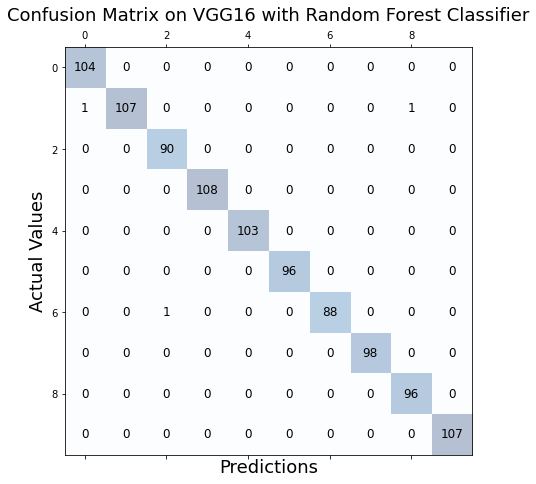

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(7.5, 7.5))
conf_matrix = np.array(cm)
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actual Values', fontsize=18)
plt.title('Confusion Matrix on VGG16 with Random Forest Classifier', fontsize=18)
# plt.savefig(path + 'confusion_matrix.tiff', dpi = 500)
plt.show()

In [ ]:
# model.save('/content/drive/MyDrive/onr_weights.h5')

In [ ]:
# saved_history = saved_model.fit(train_generator,
#               validation_data = test_generator,
#               verbose = 1,
#               epochs = 50, 
#               callbacks = [reduce_lr])  

# Graphs for comparing optimizer models

In [ ]:
adam_model = create_model(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))
adam_history = adam_model.fit(train_generator,
              validation_data = test_generator,
              verbose = 1,
              epochs = 50, 
              callbacks = [reduce_lr])  

Epoch 1/50
125/125 [==============================] - 8s 59ms/step - loss: 1.4311 - accuracy: 0.4999 - val_loss: 0.4842 - val_accuracy: 0.8460
Epoch 2/50
125/125 [==============================] - 7s 55ms/step - loss: 0.5399 - accuracy: 0.8379 - val_loss: 0.6056 - val_accuracy: 0.8550
Epoch 3/50
125/125 [==============================] - 7s 54ms/step - loss: 0.4391 - accuracy: 0.8737 - val_loss: 0.4743 - val_accuracy: 0.9010
Epoch 4/50
125/125 [==============================] - 7s 54ms/step - loss: 0.3755 - accuracy: 0.8919 - val_loss: 0.3505 - val_accuracy: 0.9100
Epoch 5/50
125/125 [==============================] - 7s 55ms/step - loss: 0.2700 - accuracy: 0.9257 - val_loss: 0.1982 - val_accuracy: 0.9450
Epoch 6/50
125/125 [==============================] - 7s 54ms/step - loss: 0.2930 - accuracy: 0.9232 - val_loss: 0.1930 - val_accuracy: 0.9510
Epoch 7/50
125/125 [==============================] - 7s 54ms/step - loss: 0.2629 - accuracy: 0.9199 - val_loss: 0.1727 - val_accuracy: 0.9520

In [ ]:
sgd_model = create_model(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.001))
sgd_history = sgd_model.fit(train_generator,
              validation_data = test_generator,
              verbose = 1,
              epochs = 50, 
              callbacks = [reduce_lr])  

Epoch 1/50
125/125 [==============================] - 8s 57ms/step - loss: 1.9728 - accuracy: 0.3322 - val_loss: 1.5131 - val_accuracy: 0.6320
Epoch 2/50
125/125 [==============================] - 7s 53ms/step - loss: 1.4642 - accuracy: 0.5311 - val_loss: 1.0141 - val_accuracy: 0.7660
Epoch 3/50
125/125 [==============================] - 6s 51ms/step - loss: 1.1432 - accuracy: 0.6365 - val_loss: 0.7505 - val_accuracy: 0.8010
Epoch 4/50
125/125 [==============================] - 6s 52ms/step - loss: 0.9577 - accuracy: 0.6965 - val_loss: 0.6070 - val_accuracy: 0.8410
Epoch 5/50
125/125 [==============================] - 6s 52ms/step - loss: 0.8056 - accuracy: 0.7426 - val_loss: 0.5124 - val_accuracy: 0.8660
Epoch 6/50
125/125 [==============================] - 7s 52ms/step - loss: 0.7287 - accuracy: 0.7688 - val_loss: 0.4582 - val_accuracy: 0.8620
Epoch 7/50
125/125 [==============================] - 7s 53ms/step - loss: 0.6541 - accuracy: 0.7928 - val_loss: 0.4117 - val_accuracy: 0.8950

In [ ]:
adagrad_model = create_model(optimizer=tf.keras.optimizers.Adagrad(learning_rate = 0.001))
adagrad_history = adagrad_model.fit(train_generator,
              validation_data = test_generator,
              verbose = 1,
              epochs = 50, 
              callbacks = [reduce_lr])  

Epoch 1/50
125/125 [==============================] - 8s 54ms/step - loss: 1.6268 - accuracy: 0.4508 - val_loss: 0.8515 - val_accuracy: 0.7660
Epoch 2/50
125/125 [==============================] - 7s 52ms/step - loss: 0.9685 - accuracy: 0.6835 - val_loss: 0.4991 - val_accuracy: 0.8680
Epoch 3/50
125/125 [==============================] - 7s 53ms/step - loss: 0.7086 - accuracy: 0.7718 - val_loss: 0.3798 - val_accuracy: 0.8880
Epoch 4/50
125/125 [==============================] - 7s 53ms/step - loss: 0.5663 - accuracy: 0.8226 - val_loss: 0.2991 - val_accuracy: 0.9210
Epoch 5/50
125/125 [==============================] - 7s 53ms/step - loss: 0.4937 - accuracy: 0.8474 - val_loss: 0.2711 - val_accuracy: 0.9210
Epoch 6/50
125/125 [==============================] - 7s 52ms/step - loss: 0.4374 - accuracy: 0.8639 - val_loss: 0.2718 - val_accuracy: 0.9160
Epoch 7/50
125/125 [==============================] - 7s 53ms/step - loss: 0.3946 - accuracy: 0.8809 - val_loss: 0.2116 - val_accuracy: 0.9400

In [ ]:
rms_model = create_model(optimizer=tf.keras.optimizers.RMSprop(learning_rate = 0.001))
rms_history = rms_model.fit(train_generator,
              validation_data = test_generator,
              verbose = 1,
              epochs = 50, 
              callbacks = [reduce_lr])  

Epoch 1/50
125/125 [==============================] - 8s 57ms/step - loss: 1.8065 - accuracy: 0.3863 - val_loss: 0.5470 - val_accuracy: 0.8160
Epoch 2/50
125/125 [==============================] - 7s 56ms/step - loss: 0.6996 - accuracy: 0.7988 - val_loss: 0.4743 - val_accuracy: 0.8870
Epoch 3/50
125/125 [==============================] - 7s 56ms/step - loss: 0.5354 - accuracy: 0.8574 - val_loss: 0.2651 - val_accuracy: 0.9360
Epoch 4/50
125/125 [==============================] - 7s 56ms/step - loss: 0.4500 - accuracy: 0.8834 - val_loss: 0.2564 - val_accuracy: 0.9410
Epoch 5/50
125/125 [==============================] - 7s 56ms/step - loss: 0.4433 - accuracy: 0.8942 - val_loss: 0.3940 - val_accuracy: 0.9060
Epoch 6/50
125/125 [==============================] - 7s 57ms/step - loss: 0.4075 - accuracy: 0.9029 - val_loss: 0.3394 - val_accuracy: 0.9120
Epoch 7/50
125/125 [==============================] - 7s 55ms/step - loss: 0.4145 - accuracy: 0.9114 - val_loss: 0.3117 - val_accuracy: 0.9270

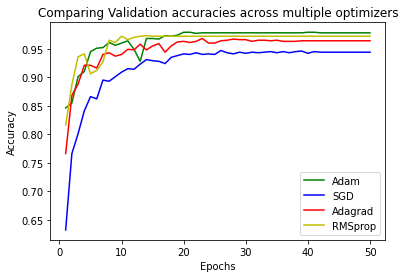

In [ ]:
import matplotlib.pyplot as plt

loss_val1 = adam_history.history['val_accuracy']
loss_val2 = sgd_history.history['val_accuracy']
loss_val3 = adagrad_history.history['val_accuracy']
loss_val4 = rms_history.history['val_accuracy']

epochs = range(1,51)

plt.plot(epochs, loss_val1, 'g', label='Adam')
plt.plot(epochs, loss_val2, 'b', label='SGD')
plt.plot(epochs, loss_val3, 'r', label='Adagrad')
plt.plot(epochs, loss_val4, 'y', label='RMSprop')

plt.title('Comparing Validation accuracies across multiple optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(path + 'Validation Accuracy Comparision Graph.tiff', dpi = 500)
plt.show()

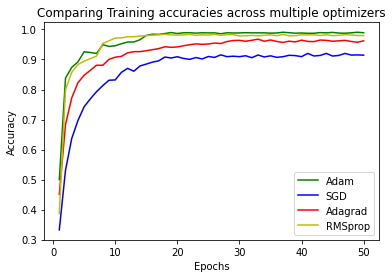

In [ ]:
import matplotlib.pyplot as plt

loss_val1 = adam_history.history['accuracy']
loss_val2 = sgd_history.history['accuracy']
loss_val3 = adagrad_history.history['accuracy']
loss_val4 = rms_history.history['accuracy']

epochs = range(1,51)

plt.plot(epochs, loss_val1, 'g', label='Adam')
plt.plot(epochs, loss_val2, 'b', label='SGD')
plt.plot(epochs, loss_val3, 'r', label='Adagrad')
plt.plot(epochs, loss_val4, 'y', label='RMSprop')

plt.title('Comparing Training accuracies across multiple optimizers')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(path + 'Training Accuracy Comparision Graph.tiff', dpi = 500)
plt.show()

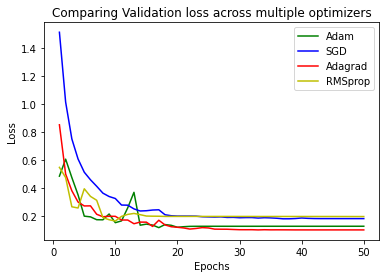

In [ ]:
import matplotlib.pyplot as plt

loss_val1 = adam_history.history['val_loss']
loss_val2 = sgd_history.history['val_loss']
loss_val3 = adagrad_history.history['val_loss']
loss_val4 = rms_history.history['val_loss']

epochs = range(1,51)

plt.plot(epochs, loss_val1, 'g', label='Adam')
plt.plot(epochs, loss_val2, 'b', label='SGD')
plt.plot(epochs, loss_val3, 'r', label='Adagrad')
plt.plot(epochs, loss_val4, 'y', label='RMSprop')

plt.title('Comparing Validation loss across multiple optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path + 'Validation Loss Comparision Graph.tiff', dpi = 500)
plt.show()

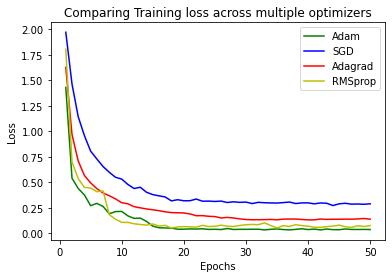

In [ ]:
import matplotlib.pyplot as plt

loss_val1 = adam_history.history['loss']
loss_val2 = sgd_history.history['loss']
loss_val3 = adagrad_history.history['loss']
loss_val4 = rms_history.history['loss']

epochs = range(1,51)

plt.plot(epochs, loss_val1, 'g', label='Adam')
plt.plot(epochs, loss_val2, 'b', label='SGD')
plt.plot(epochs, loss_val3, 'r', label='Adagrad')
plt.plot(epochs, loss_val4, 'y', label='RMSprop')

plt.title('Comparing Training loss across multiple optimizers')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path + 'Training Loss Comparision Graph.tiff', dpi = 500)
plt.show()

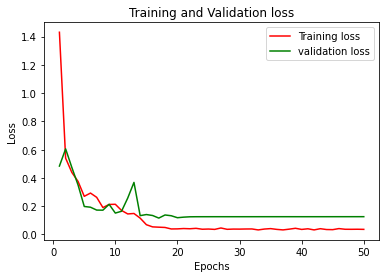

In [ ]:
import matplotlib.pyplot as plt
loss_train = adam_history.history['loss']
loss_val = adam_history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'r', label='Training loss')
plt.plot(epochs, loss_val, 'g', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(path + 'loss_graph', dpi = 500)
plt.show()
plt.close()

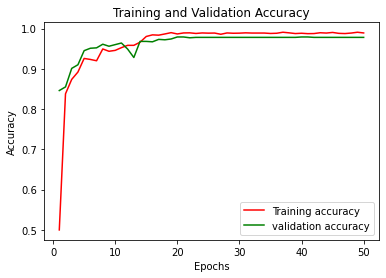

In [ ]:
import matplotlib.pyplot as plt
acc_train = adam_history.history['accuracy']
acc_val = adam_history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, acc_train, 'r', label='Training accuracy')
plt.plot(epochs, acc_val, 'g', label='validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(path + 'accuracy_graph', dpi = 500)
plt.show()
plt.close()

In [ ]:
adam_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   